<a href="https://colab.research.google.com/github/YANGJJ93MS/GNN_RT_ESI/blob/master/GNN_RT_ESI_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!git clone https://github.com/Qiong-Yang/GNN-RT.git

Cloning into 'GNN-RT'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 81 (delta 29), reused 58 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 5.40 MiB | 7.76 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [8]:
pip install rdkit

In [9]:
import pandas as pd
import numpy as np
import os
import rdkit

In [10]:
%cd GNN-RT

/content/GNN-RT/GNN-RT


In [11]:
!python preprocess.py

The code uses a GPU!


In [25]:
!python train.py

The code uses a GPU!
The code uses a GPU!
SMRT_train_set.txt
SMRT_test_set.txt
The code uses a GPU!
----------------------------------------------------------------------------------------------------
Preprocessing the dataset.
Just a moment......
----------------------------------------------------------------------------------------------------
The preprocess has finished!
# of training data samples: 63163
# of development data samples: 7019
# of test data samples: 7798
----------------------------------------------------------------------------------------------------
Creating a model.
# of model parameters: 268273
----------------------------------------------------------------------------------------------------
Start training.
The result is saved in the output directory every epoch!
The training will finish in about 2 hours 37 minutes.
----------------------------------------------------------------------------------------------------
Epoch	Time(sec)	Loss_train	MAE_train	MAE_dev	

In [43]:
from torch.utils.data import random_split
import torch
import pandas as pd

# Define the lengths of the splits
dataset = pd.read_csv('./data/TF1.csv')

# Calculate the split lengths
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
# Generate indices for splitting
train_indices, test_indices = random_split(range(len(dataset)), [train_size, test_size])

# Use the indices to split the dataset
train_df = dataset.iloc[train_indices.indices]
test_df = dataset.iloc[test_indices.indices]

# Save the training dataset as 'TF1.csv' to the .data folder
train_df.to_csv('./data/TF1.csv', index=False)

# Save the test dataset as 'TF1_test.csv' to the .data folder
test_df.to_csv('./data/TF1_test.csv', index=False)

print("Datasets have been successfully saved to the .data folder.")


Datasets have been successfully saved to the .data folder.


In [44]:
!python Transferlearning.py

The code uses a GPU!
The code uses a GPU!
The code uses a CPU!
----------------------------------------------------------------------------------------------------
The preprocess has finished!
# of training data samples: 356
# of development data samples: 40
# of test data samples: 43
----------------------------------------------------------------------------------------------------
Creating a model.
MolecularGraphNeuralNetwork(
  (embed_fingerprint): Embedding(5000, 48)
  (W_fingerprint): ModuleList(
    (0-5): 6 x Linear(in_features=48, out_features=48, bias=True)
  )
  (W_output): ModuleList(
    (0-5): 6 x Linear(in_features=48, out_features=48, bias=True)
  )
  (W_property): Linear(in_features=48, out_features=1, bias=True)
)
# of model parameters: 268273
----------------------------------------------------------------------------------------------------
Start training.
The result is saved in the output directory every epoch!
The training will finish in about 0 hours 26 minutes.


In [58]:
#predict the test dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define your model architecture
import torch
import torch.nn as nn

# Define the model architecture (this should match your transferred model)
class MolecularGraphNeuralNetwork(nn.Module):
    def __init__(self, N, dim, layer_hidden, layer_output):
        super(MolecularGraphNeuralNetwork, self).__init__()
        self.embed_fingerprint = nn.Embedding(N, dim)
        self.W_fingerprint = nn.ModuleList([nn.Linear(dim, dim) for _ in range(layer_hidden)])
        self.W_output = nn.ModuleList([nn.Linear(dim, dim) for _ in range(layer_output)])
        self.W_property = nn.Linear(dim, 1)

    def pad(self, matrices, pad_value):
        shapes = [m.shape for m in matrices]
        M, N = sum([s[0] for s in shapes]), sum([s[1] for s in shapes])
        zeros = torch.FloatTensor(np.zeros((M, N))).to(device)
        pad_matrices = pad_value + zeros
        i, j = 0, 0
        for k, matrix in enumerate(matrices):
            m, n = shapes[k]
            pad_matrices[i:i+m, j:j+n] = matrix
            i += m
            j += n
        return pad_matrices

    def update(self, matrix, vectors, layer):
        hidden_vectors = torch.relu(self.W_fingerprint[layer](vectors))
        return hidden_vectors + torch.matmul(matrix, hidden_vectors)

    def sum(self, vectors, axis):
        sum_vectors = [torch.sum(v, 0) for v in torch.split(vectors, axis)]
        return torch.stack(sum_vectors)

    def gnn(self, inputs):
        Smiles, fingerprints, adjacencies, molecular_sizes = inputs
        fingerprints = torch.cat(fingerprints)
        adjacencies = self.pad(adjacencies, 0)
        fingerprint_vectors = self.embed_fingerprint(fingerprints)
        for l in range(layer_hidden):
            hs = self.update(adjacencies, fingerprint_vectors, l)
            fingerprint_vectors = F.normalize(hs, 2, 1)
        molecular_vectors = self.sum(fingerprint_vectors, molecular_sizes)
        return Smiles, molecular_vectors

    def mlp(self, vectors):
        for l in range(layer_output):
            vectors = torch.relu(self.W_output[l](vectors))
        outputs = self.W_property(vectors)
        return outputs

    def forward_predict(self, data_batch):
        inputs = data_batch
        Smiles, molecular_vectors = self.gnn(inputs)
        predicted_values = self.mlp(molecular_vectors)
        predicted_values = predicted_values.to('cpu').data.numpy()
        predicted_values = np.concatenate(predicted_values)
        return Smiles, predicted_values

# Load the model parameters
N = 5000  # Match this to your training setup
dim = 48
layer_hidden = 6
layer_output = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MolecularGraphNeuralNetwork(N, dim, layer_hidden, layer_output).to(device)
model.load_state_dict(torch.load('./data/model.h5', map_location=device))
model.eval()  # Set the model to evaluation mode


MolecularGraphNeuralNetwork(
  (embed_fingerprint): Embedding(5000, 48)
  (W_fingerprint): ModuleList(
    (0-5): 6 x Linear(in_features=48, out_features=48, bias=True)
  )
  (W_output): ModuleList(
    (0-5): 6 x Linear(in_features=48, out_features=48, bias=True)
  )
  (W_property): Linear(in_features=48, out_features=1, bias=True)
)

In [59]:
from preprocess import transferlearning_dataset_predict

# Assume test_df is your test DataFrame
test_smiles = test_df['smiles'].tolist()  # Extract SMILES strings
test_data = transferlearning_dataset_predict(test_smiles, './data/')


In [60]:
batch_test = 32  # Define your batch size

# Define the Tester class to handle predictions
class Tester(object):
    def __init__(self, model):
        self.model = model

    def test_predict(self, dataset):
        N = len(dataset)
        SMILES, Ys = '', []
        for i in range(0, N, batch_test):
            data_batch = list(zip(*dataset[i:i+batch_test]))
            Smiles, predicted_values = self.model.forward_predict(data_batch)
            SMILES += ' '.join(Smiles) + ' '
            Ys.append(predicted_values)
        SMILES = SMILES.strip().split()
        Y = np.concatenate(Ys)
        return SMILES, Y

# Make predictions
tester = Tester(model)
predicted_smiles, predicted_values = tester.test_predict(test_data)

# Save predictions
predictions_df = pd.DataFrame({
    'smiles': predicted_smiles,
    'predicted': predicted_values
})
predictions_df.to_csv('./data/predictions.csv', index=False)
print("Predictions saved to './data/predictions.csv'")


Predictions saved to './data/predictions.csv'


In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming your test_df has a column 'actual' with the true values
actual_values = test_df['RT'].tolist()

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
r2 = r2_score(actual_values, predicted_values)

print(f"MAE: {mae}, RMSE: {rmse}, R²: {r2}")

MAE: 1.4648293292216767, RMSE: 1.9044451633932822, R²: 0.5508190025849122


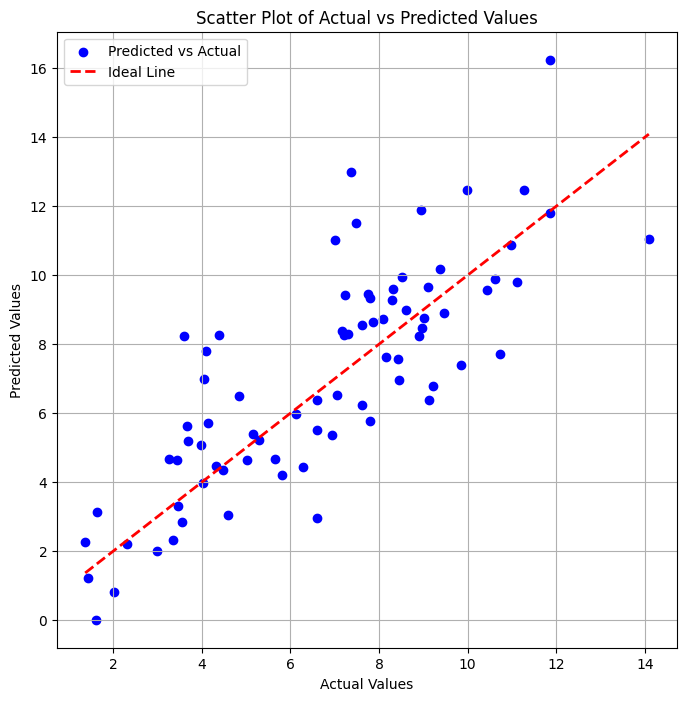

In [63]:
import matplotlib.pyplot as plt

# Assuming you have these from your previous steps
# actual_values = test_df['actual'].tolist()  # Replace with actual values from your DataFrame
# predicted_values = predicted_values  # This comes from the model prediction

# Create the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(actual_values, predicted_values, c='blue', marker='o', label='Predicted vs Actual')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], 'r--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.savefig('./data/actual_vs_predicted.png', dpi=300)  # Save the figure
plt.show()
